# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python


tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print("Brain name: {},  Brain: {}".format(brain_name, brain))


Brain name: BananaBrain,  Brain: Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)


Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
env.close()



### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

#### 4.1 The agent model

The agent model is based on a configurable Double DQN. The value/advantage streams are enabled with `dueling=True` (default). The in terms of architecture details model start with a 128-units linear layer followed by a `ReLU` activation. The dueling streams have each a 256-unit linear FC layer followed by a `ReLU` activation. For advantage offsetting we are using mean-shifting instead of max.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, drop=False, 
                 dueling=True):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            drop:  use dropout in model
            dueling: use stream splitting for adv/value 
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.conv_blocks = []
        self.dense_blocks = [128]
        self.dueling = dueling
        self.action_size = action_size
        print("Initializing QNetwork: dueling={}".format(dueling))
        
        self.relu = nn.ReLU()
        
        if len(self.conv_blocks) > 0:      
          self.convs = nn.ModuleList()
          prev_conv = 1
          for nrch in self.conv_blocks[:-1]:
            self.convs.append(nn.Conv2d(prev_conv, nrch, kernel_size=3, stride=1, padding=1))
            self.convs.append(nn.ReLU())
            self.convs.append(nn.MaxPool2d(2,2))
            prev_conv = nrch

          nrch = self.conv_blocks[-1]
          self.convs.append(nn.Conv2d(prev_conv, nrch, kernel_size=3, stride=1, padding=1))

        if len(self.dense_blocks) > 0:
          self.denses = nn.ModuleList()      
          prev_dense = state_size
          for nrunits in self.dense_blocks:
            self.denses.append(nn.Linear(in_features=prev_dense, out_features=nrunits))
            self.denses.append(nn.ReLU())
            if drop:
              self.denses.append(nn.Dropout(p=0.5))
            prev_dense = nrunits
        
        if self.dueling:
          self.pre_adv_layer = nn.Linear(prev_dense, 256)          
          self.pre_val_layer = nn.Linear(prev_dense, 256)
          self.adv_layer = nn.Linear(256, action_size)
          self.val_layer = nn.Linear(256, 1)
        else:
          self.denses.append(nn.Linear(in_features=prev_dense, out_features=action_size))



    def forward(self, x):
        if len(self.conv_blocks) > 0:
          for _layer in self.convs:
            x = _layer(x)
          x = x.view(x.size(0), -1)
        if len(self.dense_blocks) > 0:      
          for _layer in self.denses:
            x = _layer(x)        
        
        if self.dueling:
          x_adv = self.relu(self.pre_adv_layer(x))
          x_adv = self.adv_layer(x_adv)
          #x_adv_mean = x_adv.mean(1).unsqueeze(1)
          #x_adv_mean = x_adv_mean.expand(-1, self.action_size)
          x_adv_mean = x_adv.mean(1, keepdim=True)

          x_val = self.relu(self.pre_val_layer(x))
          x_val = self.val_layer(x_val)
          #x_val = x_val.expand(-1, self.action_size)
          x_offseted = x_adv - x_adv_mean
          x = x_val + x_offseted
          
        # final output
        return x


#### 4.2 The Agent and it's replay buffer

The agent can be configured to use either simple of double DQN training approach with `doble_dqn=True` (default). The models are by default created with `dueling=True` based on the agent constructor. A simple GPU capability analysis method has been added.

In [7]:
import random
import torch.optim as optim
from collections import namedtuple, deque
import numpy as np

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_device_info(dev=None):  
  if torch.cuda.is_available():
    if dev is None:
      dev = torch.device("cuda:0")
    if int(torch.__version__[0]) > 0:
      _dev = dev
    else:
      _dev = dev.index
    gpu = torch.cuda.get_device_properties(_dev)
    return gpu.name, gpu.total_memory / (1024**3), gpu.multi_processor_count
  else:
    return None, None, None

class Agent():
    """Interacts with and learns from the environment."""

    
    def __init__(self, state_size, action_size, seed, 
                 double_dqn=True, dueling=True):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            double_dqn: use DDQN
            dueling: use adv/value stream split in model
        """
        self.state_size = state_size
        self.action_size = action_size
        self.double_dqn = double_dqn
        self.dueling = dueling
        self.seed = random.seed(seed)

        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed,
                                       dueling=self.dueling).to(device)
        print("Agent model:")
        print(self.qnetwork_local)
        var_device = next(self.qnetwork_local.denses.parameters()).device
        dev_name, _, _ = get_device_info(var_device)
        print(" Running on '{}':{}".format(var_device, dev_name))
        print(" Double DQN: '{}'".format(self.double_dqn))
        print(" Dueling DQN: '{}'".format(self.dueling))
        self.qnetwork_target = QNetwork(state_size, action_size, seed,
                                        dueling=self.dueling).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences                
                
        target_values = self.qnetwork_target(next_states).detach()
        
        if self.double_dqn:
            local_next_values = self.qnetwork_local(next_states)
            _, local_next_actions = torch.max(local_next_values, 1)
            local_next_actions = local_next_actions.detach().unsqueeze(1) # or keepdim=True 
            next_max_values = torch.gather(target_values, 1, local_next_actions)
        else:
          next_max_values, next_best_actions = target_values.max(1)
          next_max_values = next_max_values.unsqueeze(1) # or keepdim=True 
          
        targets = rewards + gamma * next_max_values * (1 - dones)
        
        outputs = self.qnetwork_local(states)
        
        selected_outputs = torch.gather(outputs, 1, actions)
        
        self.optimizer.zero_grad()
        loss = self.loss_func(selected_outputs, targets)
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### 4.3 The training method

Next we define the core of the training loop - the `dqn_train` function. The functions  displays numerous debug information and logs all this training informatio in the `training_X.log` file where (`X` denotes the training iteration). The training loop returns the `scores` and also the `i_episode` - number of episodes that were needed to find a solution.


In [8]:
from time import time

def dqn_train(agent, n_episodes=2000, max_t=300, 
              eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              training_iteration=1):
    """Deep Q-Learning.
    
    Params
    ======
        agent : Agent() instance
        training_iteration : int identifier of the training iteration
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    training_log = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    t_last = time()
    t_start_time = t_last
    training_log.append("Training iteration {}...".format(training_iteration))
    print(training_log[-1])    
    training_log.append("  eps_start={}  eps_min={}  eps_decay={}".format(eps_start, eps_end, eps_decay))
    print(training_log[-1])    
    min_score = np.inf
    max_score = -np.inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0  
        t_start = time()
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                min_score = min(min_score, score)
                max_score = max(max_score, score)
                break 
        t_ep = time() - t_start
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {:>4}  Score: {:>4}  AvgS: {:>4.1f}  Eps: {:.4f}  Time: {:.1f}s / {:>4} steps '.format(
            i_episode, score, np.mean(scores_window), eps, t_ep, t, ), end="", flush=True)
        if i_episode % 100 == 0:
            t_lap = time() - t_last
            t_last = time()            
            _s = '\rEpisode {:>4}  AvgS: {:>4.1f}  [{:>4.1f} - {:>4.1f}]  Eps: {:.4f}  AvgTime: {:.1f}s/ep\t\t\t\t'.format(
                i_episode, np.mean(scores_window), min_score, max_score, eps, t_lap / 100)
            print(_s, flush=True)
            training_log.append(_s[1:])
            min_score = np.inf
            max_score = -np.inf
        if np.mean(scores_window)>=13.0:
            training_log.append('\nEnvironment (well) solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_window)))
            print(training_log[-1])
            torch.save(agent.qnetwork_local.state_dict(), 'model_{}.pt'.format(training_iteration))
            break
    t_full_train = time() - t_start_time
    training_log.append("Training iteration {} done in {:.1f} hrs".format(training_iteration, t_full_train / 3600))
    print(training_log[-1])

    with open('training_{}.log'.format(training_iteration), "wt") as f:
        for _l in training_log:
            f.write(_l)
    return scores, i_episode



#### 4.4  Training with grid-search 

This is the part where all the exploration and learning is done. The actual training loop execution uses the `dqn_train` functions in order to iterate through multiple dictionaries of hyperparameters within the `settings` list. The list can be either manually or grid-search generated (random or exhaustive). The first part uses the previously defined `get_device_info` to show GPU-related info if available.

In [9]:


n, m, p = get_device_info()
if n:
  print("GPU: {}, Mem:{:.1f}GB, Procs:{}".format(n, m, p))
  
settings = [
    {"double" : True,
     "dueling" : True,
     "eps_start" : 1.0,
     "eps_min" : 0.05,
     "eps_decay" : 0.995,
    },
    {"double" : True,
     "dueling" : True,
     "eps_start" : 0.9,
     "eps_min" : 0.05,
     "eps_decay" : 0.99,
    }
    
    ]

grid_scores = []

for i,_set in enumerate(settings):  
    double_dqn = _set['double']
    dueling = _set['dueling']
    eps_start, eps_end, eps_decay = _set["eps_start"], _set["eps_min"], _set["eps_decay"]
  
    eng = Agent(state_size=37, action_size=4, seed=0,                 
                double_dqn=double_dqn, dueling=dueling)  

    scores, nepisodes = dqn_train(agent=eng, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay,training_iteration=i+1)
    grid_scores.append((_set, scores, nepisodes))


GPU: Tesla K80, Mem:11.2GB, Procs:13
Initializing QNetwork: dueling=True
Agent model:
QNetwork(
  (relu): ReLU()
  (denses): ModuleList(
    (0): Linear(in_features=37, out_features=128, bias=True)
    (1): ReLU()
  )
  (pre_adv_layer): Linear(in_features=128, out_features=256, bias=True)
  (pre_val_layer): Linear(in_features=128, out_features=256, bias=True)
  (adv_layer): Linear(in_features=256, out_features=4, bias=True)
  (val_layer): Linear(in_features=256, out_features=1, bias=True)
)
 Running on 'cuda:0':Tesla K80
 Double DQN: 'True'
 Dueling DQN: 'True'
Initializing QNetwork: dueling=True
Training iteration 1...
  eps_start=1.0  eps_min=0.05  eps_decay=0.995
Episode  100  AvgS:  0.7  [-3.0- 4.0]  Eps: 0.6058  AvgTime: 1.5s/ep			teps 
Episode  200  AvgS:  3.7  [-1.0-12.0]  Eps: 0.3670  AvgTime: 1.6s/ep			teps 
Episode  300  AvgS:  6.0  [-1.0-17.0]  Eps: 0.2223  AvgTime: 1.6s/ep			teps 
Episode  400  AvgS:  9.9  [ 0.0-17.0]  Eps: 0.1347  AvgTime: 1.6s/ep			teps 
Episode  500  Avg

#### 4.5 Plotting the results

Finally we plot the results for the best grid search iteration allong with the found parameters. The best training iteration is considered the one with the smallest amount of steps until a solution is found.

Best hyperparameters:
  Double DQN:  True
  Dueling DQN: True
  eps_start:   0.9
  eps_min:     0.05
  eps_decay:   0.99
Results for last 100 episodes:
  Min score: 5.0
  Max score: 23.0
  Avg score: 13.0
  Med score: 13.0


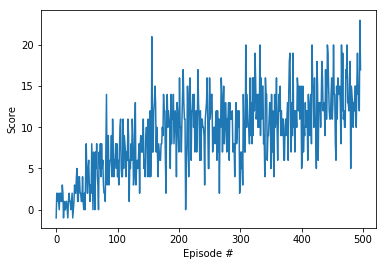

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt

grid_scores = sorted(grid_scores, key=lambda x:x[2]) # we sort based on number of required episodes 


info, scores, nepisodes = grid_scores[0] # get best iteration (smaller number of episodes is better)

print("Best hyperparameters:")
print("  Double DQN:  {}".format(info['double']))
print("  Dueling DQN: {}".format(info['dueling']))
print("  eps_start:   {}".format(info['eps_start']))
print("  eps_min:     {}".format(info['eps_min']))
print("  eps_decay:   {}".format(info['eps_decay']))

print("Results for last 100 episodes:")
print("  Min score: {:.1f}".format(np.min(scores[-100:])))
print("  Max score: {:.1f}".format(np.max(scores[-100:])))
print("  Avg score: {:.1f}".format(np.mean(scores[-100:])))
print("  Med score: {:.1f}".format(np.median(scores[-100:])))


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

